In [3]:
setwd('/home/other/jpf5265/DnDs-visualization/test_dataset/')

In [23]:
library(dplyr)
# Load the datasets
taxonomy <- read.csv('marinus_taxonomy.csv')
dnds <- read.csv('dnds_constant_15.csv')

# Drop rows where column dNdS_ratio or column dNdS_ratio_constant is NA
dnds <- dnds %>%
  filter(!is.na(dNdS_ratio) & !is.na(dNdS_ratio_constant))


# Convert CSV to tibble table so that we can use parse_tax_data
taxonomy_tibble <- as_tibble(taxonomy)

# Concatenate taxonomic columns into a single "lineage" column
# data <- taxonomy_tibble %>%
#   mutate(lineage = paste("r__Root",
#                          paste0("p__", phylum),
#                          paste0("c__", class),
#                          paste0("o__", order),
#                          paste0("f__", family),
#                          paste0("g__", genus),
#                          paste0("s__", species),
#                          sep = ";")) %>%
#   select(NCBI_fasta_name, custom_fasta_name, lineage, strain)
data <- taxonomy_tibble %>%
  mutate(lineage = paste(
                         paste0("p__", phylum),
                         paste0("c__", class),
                         paste0("o__", order),
                         paste0("f__", family),
                         paste0("g__", genus),
                         paste0("s__", species),
                         sep = ";")) %>%
  select(NCBI_fasta_name, custom_fasta_name, lineage, strain)



In [5]:
library(metacoder)
obj <- parse_tax_data(data,
                      class_cols = "lineage", # the column that contains taxonomic information
                      class_sep = ";", # The character used to separate taxa in the classification
                      class_regex = "^(.+)__(.+)$", # Regex identifying where the data for each taxon is
                      class_key = c(tax_rank = "info", # A key describing each regex capture group
                                    tax_name = "taxon_name"))


This is metacoder version 0.3.7 (stable)



In [25]:
# Load the data
taxonomy <- read.csv('marinus_taxonomy.csv')
dnds <- read.csv('dnds_constant_15.csv')

# Drop rows where column dNdS_ratio or column dNdS_ratio_constant is NA
dnds <- dnds %>%
  filter(!is.na(dNdS_ratio) & !is.na(dNdS_ratio_constant))


# Merge the dataframes to include taxonomic information for both A and B
merged_data <- dnds %>%
  left_join(taxonomy, by = c("A" = "custom_fasta_name")) %>%
  left_join(taxonomy, by = c("B" = "custom_fasta_name"), suffix = c("_A", "_B"))

# # # Create combined taxonomic columns
# # merged_data <- merged_data %>%
# #   mutate(lineage_A = paste("r__Root", paste0("p__", phylum_A), paste0("c__", class_A), 
# #          paste0("o__", order_A), paste0("f__", family_A), paste0("g__", genus_A), paste0("s__", species_A), 
# #          sep = ";"),
# #          lineage_B = paste("r__Root", paste0("p__", phylum_B), paste0("c__", class_B), 
# #          paste0("o__", order_B), paste0("f__", family_B), paste0("g__", genus_B), paste0("s__", species_B), 
# #          sep = ";"))

# Function to compare and generate new column 
# (for each level, identify if genome A and genome B have the same taxonomic classification,
# if they do, return the classification, if they don't, return "Unmatched")
compare_columns <- function(df, col_A, col_B) {
  ifelse(df[[col_A]] == df[[col_B]], df[[col_A]], "Unmatched")
}

# Creating new columns based on the comparison
merged_data$phylum <- compare_columns(merged_data,"phylum_A", "phylum_B")
merged_data$class <- compare_columns(merged_data,"class_A", "class_B")
merged_data$order <- compare_columns(merged_data,"order_A", "order_B")
merged_data$family <- compare_columns(merged_data,"family_A", "family_B")
merged_data$genus <- compare_columns(merged_data,"genus_A", "genus_B")
merged_data$species <- compare_columns(merged_data,"species_A", "species_B")





In [24]:
# Function to calculate averages
calculate_averages <- function(df, taxon_level) {
# sym(taxon_level) converts the string of each taxonomic level (such as "phylum", "order") 
# into a symbol that group_by can use. 
# (!!): unquotes the symbol, making group_by captures the actual taxonomic level rather than the expression

  df %>%
    group_by(!!sym(taxon_level)) %>% #
    summarise(
      average_dnds = mean(dNdS_ratio, na.rm = TRUE),
      average_dnds_constant = mean(dNdS_ratio_constant, na.rm = TRUE)
    ) %>%
    rename(taxon = !!sym(taxon_level)) # Change the name of the grouping column to taxon
}

# Calculate averages for each taxonomic level
average_phylum <- calculate_averages(merged_data, "phylum")
average_class <- calculate_averages(merged_data, "class")
average_order <- calculate_averages(merged_data, "order")
average_family <- calculate_averages(merged_data, "family")
average_genus <- calculate_averages(merged_data, "genus")
average_species <- calculate_averages(merged_data, "species")

# Combine all results into one dataframe
average_data <- bind_rows(
  average_phylum %>% mutate(level = "Phylum"),
  average_class %>% mutate(level = "Class"),
  average_order %>% mutate(level = "Order"),
  average_family %>% mutate(level = "Family"),
  average_genus %>% mutate(level = "Genus"),
  average_species %>% mutate(level = "Species")
)

In [8]:
taxon_names<-obj$taxon_names()

# Function to get average values for a specific taxon name

# Average dnds
get_average_dnds <- function(taxon_name) {
  avg_row <- average_data %>%
    filter(taxon == !!taxon_name) %>%
    select(average_dnds) 
    
  return(avg_row$average_dnds) # Extract average dnds value only
}

# Average dnds with constant
get_average_dnds_constant <- function(taxon_name) {
  avg_row <- average_data %>%
    filter(taxon == !!taxon_name) %>%
    select(average_dnds_constant)  

  return(avg_row$average_dnds_constant) # Extract average dnds with constant only
}



In [9]:
# Create vectors of average dnds and average dnds with constant

# sapply takes each element in taxon_names (obj$taxon_names()) and passes it to the get_average_dnds 
# and get_average_dnds_constant function.
average_dnds_values <- sapply(taxon_names, get_average_dnds) 
average_dnds_constant_values <- sapply(taxon_names, get_average_dnds_constant)

# Ensure the values are numeric and remove NA values where taxon_name is not found in the average_data
average_dnds_values <- na.omit(as.numeric(average_dnds_values))
average_dnds_constant_values <- na.omit(as.numeric(average_dnds_constant_values))



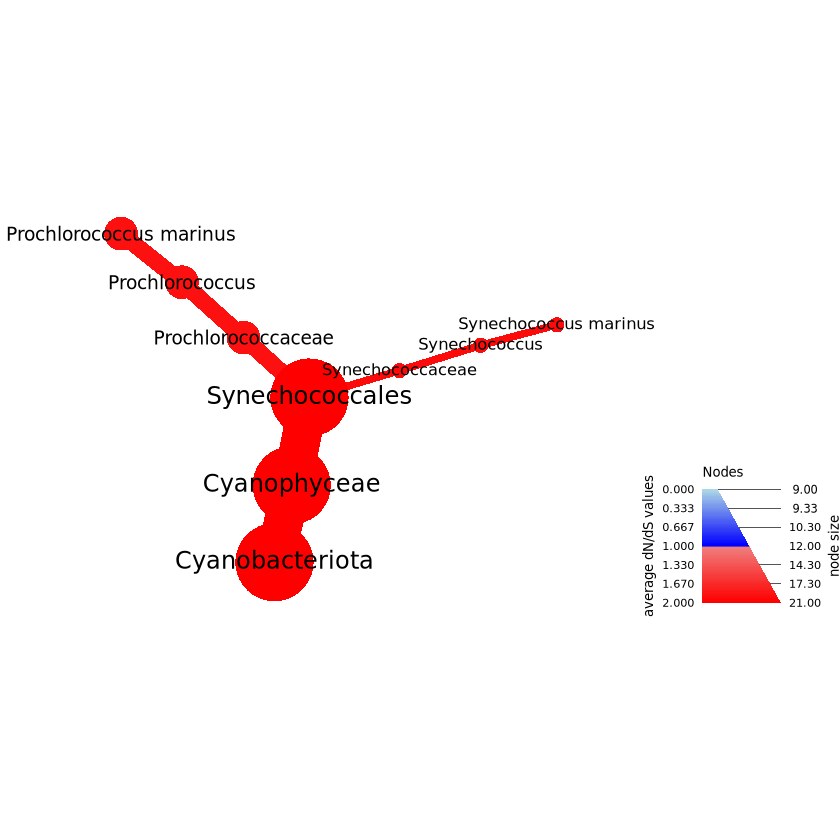

In [26]:
library(scales)
# Create a gradient of colors
blue_gradient <- colorRampPalette(c("lightblue", "blue"))(100) # generates 100 different shades within this gradient
red_gradient <- colorRampPalette(c("lightcoral", "red"))(100)

# Function to map dnds values to appropriate colors
# sapply applies a function to each average dnds and average dnds with constant
map_dnds_to_colors <- function(dnds_values) {
  colors <- sapply(dnds_values, function(x) {
    if (is.na(x)) {
      return(NA)
    } else if (x < 1) {

      # rescales x from the range [0, 1] to the range [1, 100] and  converts this rescaled value to an integer index
      # since colorRampPalette generates 100 colors indexed from 1 to 100
      return(blue_gradient[as.integer(rescale(x, to = c(1, 100), from = c(0, 1)))])
    } else {
      return(red_gradient[as.integer(rescale(x, to = c(1, 100), from = c(1, max(dnds_values, na.rm = TRUE))))])
    }
  })
  return(colors)
}

# Apply the function to average dnds values and average dnds values with constant
node_colors <- map_dnds_to_colors(average_dnds_values)

set.seed(10) # This makes the plot appear the same each time it is run 
# Create the heat tree with custom node colors and adjusted font size
heat_tree(obj, 
          node_label = obj$taxon_names(),
          node_size = obj$n_obs(), # The number of observations for each taxon
          node_color = node_colors,
          node_color_range = c(blue_gradient, red_gradient), # Ensure the legend reflects the custom color mapping
          node_color_trans = "linear", # Ensure linear transition
          node_color_interval = c(0, 2), # Ensure color transition happening at the midpoint (1) between 0 and 2
          node_color_axis_label = "average dN/dS values",
          node_size_axis_label = "node size",
          layout = "davidson-harel", # The primary layout algorithm
          initial_layout = "reingold-tilford", # The layout algorithm that initializes node locations
          node_label_size_range = c(0.04, 0.06)) # Adjust the font size range